# Nonparametric Regression

## Introduction
This notebook will discuss nonparametric regression which is a generalization of the standard linar regression model. The primary model of interest now is $$y_{i} = f(x_{i}) + \epsilon_{i},$$ where $f(x)$ is the nonparametric component which we would like to estimate. Rather than parametrizing $E(Y|X)$ as is done in linear regression, we estimate it directly. This type of regression model is usefull when working with nonlinear data. There are three well known estimation strategies that will be discussed in this notebook: 1) polynomial regression 2) kernel regression, and 3) spline regression. 



## Generate Nonlinear Data

Let us begin by generating some nonlinear relationship between two variables. Then we will discuss how to model this nonlinear relationship using different estimation strategies. The nonlinear relationship we will generate is 
$$y_{n} = sin(\frac{n}{10}) + (\frac{n}{50})^2 + \epsilon$$ where $\epsilon$ is normally distributed noise. 

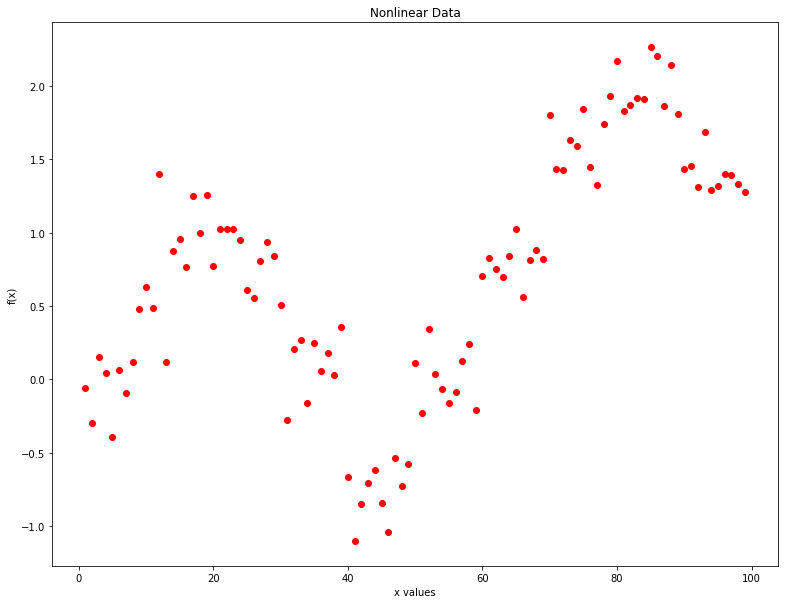

In [16]:
# Import the standard libraries
# Matrix computation
import numpy as np

# Plotting
from matplotlib.pyplot import *

# Code below will generate non-linear data
# Support varies from [1,100]
xval = range(1,100)

# Generate y-values on support
def nonlinear(x):
    
    # Generate random vector
    epsilon = np.random.normal(0, 0.2, len(x)+1)
    
    # Nonlinear data with noise
    ynonlinear = [np.sin(i/10) + (i/50)**2 + epsilon[i] for i in x]
    
    return ynonlinear


# yval = sin(xval/10) + (x/50).^2 + eps
yval = nonlinear(xval)

# Change size of figures
fig_size = [13,10]
rcParams["figure.figsize"] = fig_size

# Plot generated data
plot(xval,yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data")
show()

The above data is clearly nonlinear. Hence a linear model such as $y = b_{0} + b_{1}x$ would be a bad fit to the data.

## Polynomial regression

We will start by fitting a three degree polynomial to the above nonlinear data. This means the model we are interested in is $y = b_{0} + b_{1}x + b_{2}x^2 + b_{3}x^3.$ Recall that for a linear regression we can obtain the vector of estimates using $$ b = (X'X)^{-1}X'y,$$ where $X$ is a $N \times 4$ matrix containing the columns $X = [1 \ x \ x^2 \ x^3].$


In [17]:
# Code below estimate beta using inv(X'X)X'y
# Implement closed form solutions for linear regression
def estimate_model(y,X):
    
    # X transpose
    Xtranspose = np.matrix.transpose(X)
    
    # Closed form solution is BetaHat = inv(X'X)*X'y
    BetaHat = np.dot(np.linalg.inv(np.dot(Xtranspose,X)),np.dot(Xtranspose,y))
    
    return BetaHat


In [18]:
# Outcome vector
outcome = np.array(yval)

# Fit nonlinear data using a polynomial 
# Design matrix components
# Column of ones (for intercept)
ones = np.ones(len(yval))

# x^2 column
xval_2 = [i ** 2 for i in xval]

# x^3 column
xval_3 = [i ** 3 for i in xval]

# Design matrix [1, x, x^2, x^3]
design = np.column_stack([ones, xval, xval_2, xval_3])

# Estimate (Beta0, ..., Beta4) for linear regression model
betahat = estimate_model(outcome,design)
print ('Estimate of regression parameters: %s' %betahat)

Estimate of regression parameters: [  7.80373509e-01  -4.69092083e-02   9.28778667e-04  -3.30409301e-06]


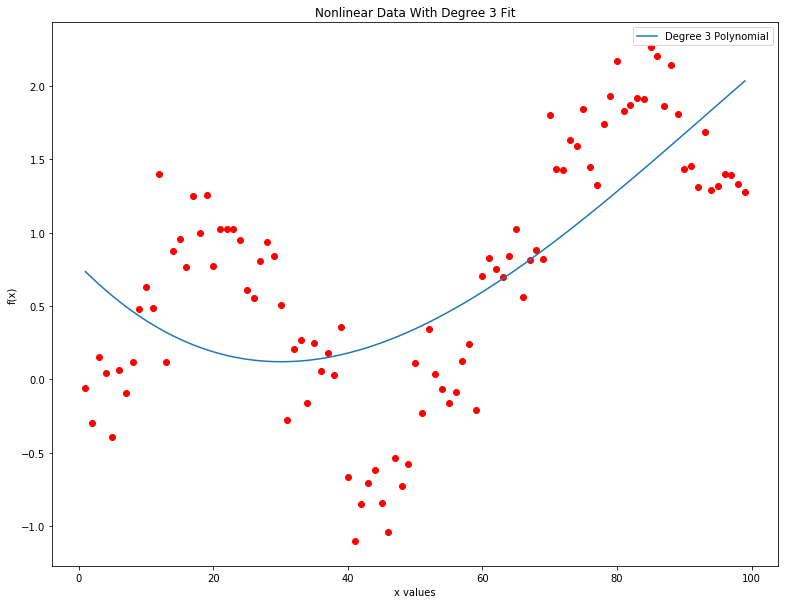

In [19]:
# Plot the non-linear data together with degree 3 fit
#Scatter plot of non-linear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Degree 3 Fit")

# Plot linear regression (degree 3)
pred_yhat = betahat[0] + betahat[1]*np.asarray(xval) + betahat[2]*np.asarray(xval_2) + betahat[3]*np.asarray(xval_3)
simple, = plot(xval, pred_yhat)

# Legend for linear regression scatter plot
legend([simple], ['Degree 3 Polynomial'])
show()

Although the three degree polynomial captures the overall increasing trend in the data, it does not perform well in fitting all the nonlinearities. You can adjust the above code to fit higher degree polynomials. You will notice that higher order polyonomials will either underfit or overfit the above scatter plot. 

## Gaussian kernel regression

The gaussian kernel regression essential predicts $f(x^*)$ by taking the weighted average of the data as follows:
$$ f(x^*) = \sum_{i=1}^{n} w(x^*,x_{i})y_{i},$$ where $w(x^*,x_{i})$ represents the weight. The reason its called "Gaussian" kernell regression is because the weights come from a normal distribution:
$$w(x^*, x_{i}) = \frac{K(\frac{x_{i} - x^*}{h})}{\sum_{i=1}^{n} K(\frac{x_{i} - x^*}{h})}, $$ where $h =$ bandwidth and $K(a) = \frac{exp(\frac{-a^2}{2})}{\sqrt{2\pi}}.$ Note that $K(a)$ integrates to 1 over its domain and is symmetric. This is a general property of kernels, there are many of them, we are just consider the popular "gassian kernel". If you look closely at the weight formula, you will notice that points close to $x^*$ recieve higher weighting than points far away from $x^*.$ Hence $f(x^*)$ is essentially a weighted average of points close to $x^*.$ 

The tuning parameter $h$ is chosen by the researcher, this is generally found using cross validation, a procedure we wont cover in this notebook. $h$ is also known as the "bandwith", this is because if $h$ is large than more points close to $x^*$ will recieve significant wieght. 

Other than determining $h,$ the gaussian kernel regression does not need to estimate any other parameters. Let us now fit the gaussian kernel regression to the nonlinear data above. 

In [20]:
# Gaussian kernell regression
# This function is the primary function used to predict f(x) using gaussian kernell weights
# x, y are data vector, h is bandwidth, and x0 is point of prediction
def gauss_kern(x,y, x0, h):
    
    # Define exp(-0.5((x - x0)/h)^2)
    gauss_term = [np.exp((-0.5*(((x[i] - x0)/h)**2))) for i in range(0, len(x))]
    
    # Weight for gaussian
    w_sum = sum(gauss_term)
    weight = [gauss_term[i]/w_sum for i in range(0,len(x))];
    
    # Predict f(x0)
    y_pred = np.sum([weight[i]*y[i] for i in range(0, len(x))])
    
    return y_pred

In [21]:
# Grid of points to estimate f(x) on
grid_f = np.arange(1,len(xval),0.5)

# Initialize predictions f(x)
gauss_pred = np.zeros(len(grid_f))

# Get vector of predictions f(x) with h = 2.5
for index in range(0, len(grid_f)):
    
    # Predict f(x) for each point on grid using gaussian kernel
    gauss_pred[index] = gauss_kern(xval,yval, grid_f[index], 2.5)

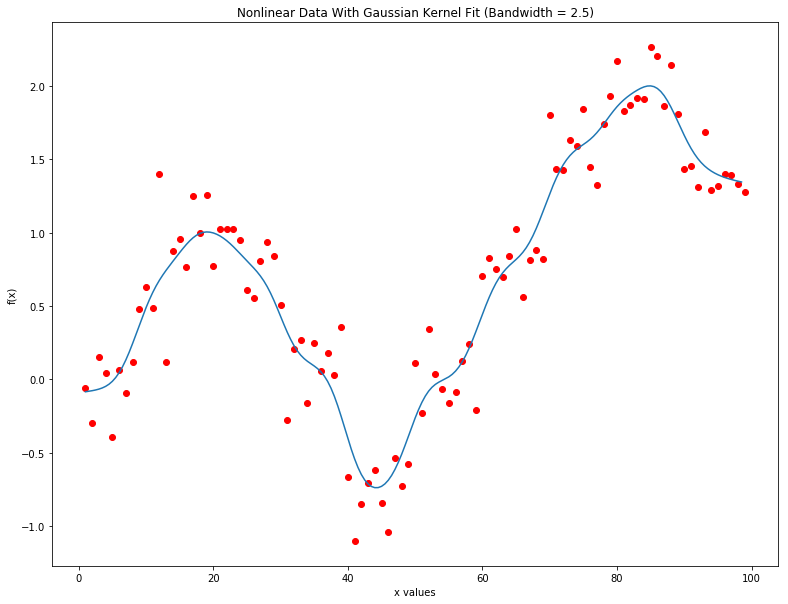

In [22]:
# Plot nonlinear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Gaussian Kernel Fit (Bandwidth = 2.5)")

# Plot fitted values f(x) from guassian kernel with h = 2.5
plot(grid_f, gauss_pred)
show()

The gaussian kernel regression with bandwith $h = 2.5$ does a fairly good job in fitting the above nonlinear data. Now let us consider smaller and larger values of $h$ and see what happens to the fit. 

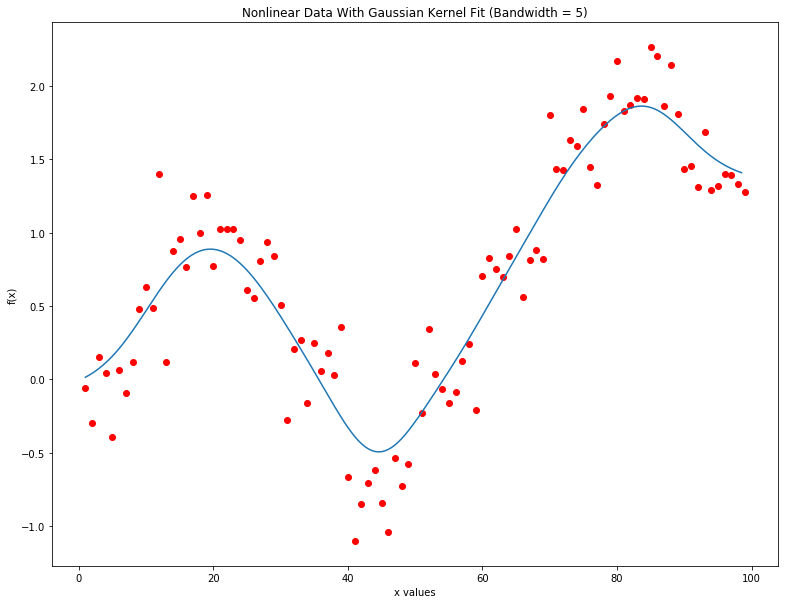

In [23]:
# Get vector of predictions f(x) with h = 5
for index in range(0, len(grid_f)):
    
    gauss_pred[index] = gauss_kern(xval,yval, grid_f[index], 5)

# Plot nonlinear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Gaussian Kernel Fit (Bandwidth = 5)")

# Plot fitted values f(x) from guassian kernel with h = 5
plot(grid_f, gauss_pred)
show()

For a large bandwith parameter of $h = 5$ we notice a much smoother fit. This is because more points around $x^*$ are given significant weight when predicting $f(x^*).$ This model fits the data well with exception to on [40,50].

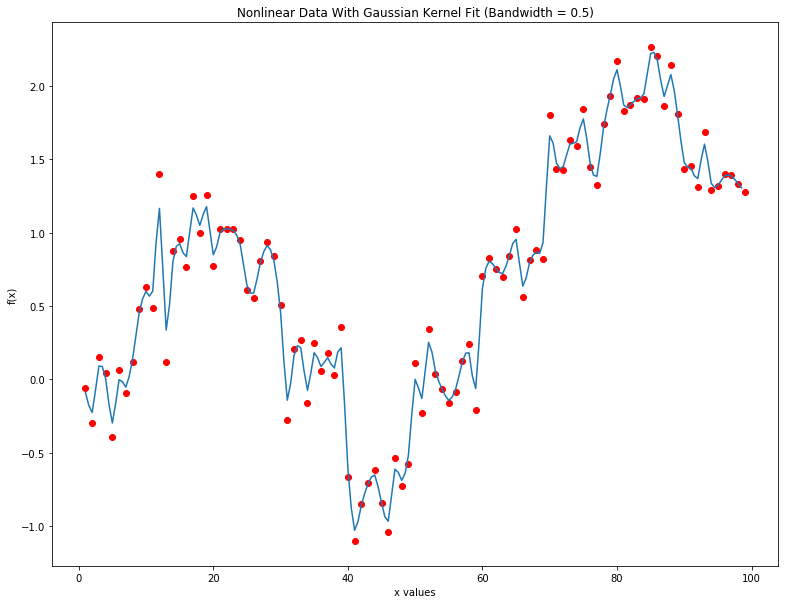

In [24]:
# Get vector of predictions f(x) with h = 0.5
for index in range(0, len(grid_f)):
    
    gauss_pred[index] = gauss_kern(xval,yval, grid_f[index], 0.5)
    
# Plot nonlinear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Gaussian Kernel Fit (Bandwidth = 0.5)")

# Plot fitted values f(x) from guassian kernel with h = 0.5
plot(grid_f, gauss_pred)
show()

For a smaller bandwith of $h = 0.5$ the guassian kernel model overfits the above nonlinear data. The predicted model is fitting too much to the noisy components (produced by the error term in y = f(x) + $\epsilon$) of the data and will be horrible for conducting out of sample prediction. 

## Spline regression

The idea behind spline regression is to partition the domain into multiple parts and fit a model to each component. For example a linear spline is just a piecewise linear function that fits the data. Similarly a quadratic spline is a piecwise function with quadratic components. The point of division is called a "knot". The number of knots (number of segements) is set by the researcher. 

A polynomial spline of degree $D$ with $K$ knots can be estimated using the following regression model:
$$y = \beta_{0} + \sum_{i=1}^{D}\beta_{i}x^i +  \sum_{j=1}^{K}\alpha_{j}I(x > C_{j})(x - C_{j})^D + \epsilon,$$ where the position of knot $j$ is denoted by $C_{j}.$ Estimating a polyonomial spline requires estimating the parameters $\theta = (\beta_{0}, \ldots, \beta_{D}, \alpha_{1}, \ldots, \alpha_{K}),$ this can be done by minimizing the least square errors (as is standard in linear regression). That is $\theta$ can be estimated as 
$$\hat{\theta} = (X'X)^{-1}X'Y,$$ where $X$ is a $N \times (D + K + 1)$ matrix with columns $X = [1 \ x \ \ldots \ x^D \ I(x > C_{1})(x-C_{1}) \ \ldots \ I(x > C_{K})(x-C_{k})].$

### Linear spline

Let us start with a linear spline with 3 knots at $\{25,50,85\}:$

$$ y = \beta_{0} + \beta_{1}x + \alpha_{1}I(x > 25)(x-25) + \alpha_{2}I(x > 50)(x-50) + \alpha_{3}I(x > 85)(x-85) + \epsilon $$

In [25]:
# Estimate parameters for linear spline
# Design matrix components
# Knot at 25
# (x - 25) * I(x > 25)
xval_q1 = [0 if i < 25 else (i - 25) for i in xval]

# Knot at 50
# (x - 50) * I(x > 50)
xval_q2 = [0 if i < 50 else (i - 50) for i in xval]

# Knot at 85
# (x - 85) * I(x > 85)
xval_q3 = [0 if i < 85 else (i - 85) for i in xval]

# Design matrix [1, x, (x-25) * I(x > 25), (x-50) * I(x > 50),(x-75) * I(x > 75)]
design_spline = np.column_stack([ones, xval, xval_q1, xval_q2, xval_q3])

# Estimate (Beta0, ..., Beta5) for linear regression model
betahat = estimate_model(outcome,design_spline)
print ('Estimate of linear spline parameters: %s' %betahat)

Estimate of linear spline parameters: [ 0.03917604  0.03300482 -0.09113127  0.14134092 -0.17565041]


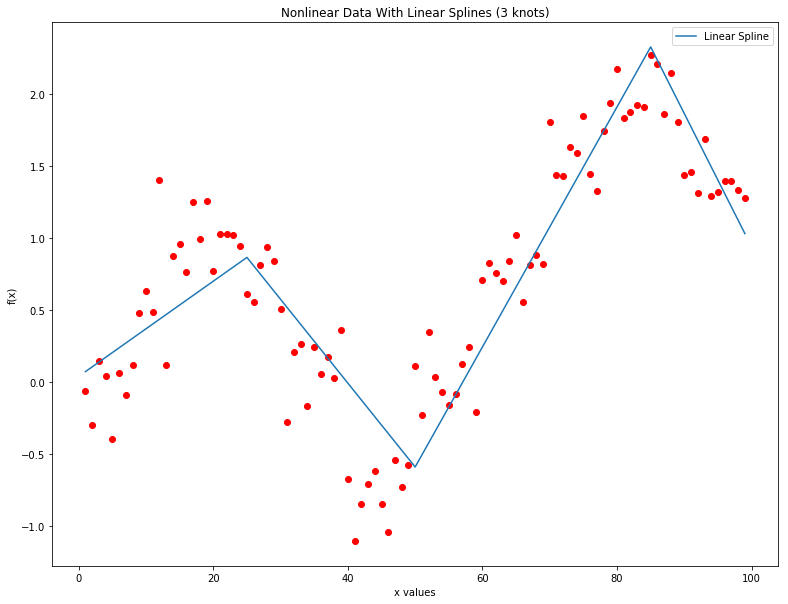

In [26]:
# Plot the non-linear data together with linear splines
#Scatter plot of non-linear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Linear Splines (3 knots)")

# Plot linear regression (degree 3)
pred_yhat = betahat[0] + betahat[1]*np.asarray(xval) + betahat[2]*np.asarray(xval_q1) + betahat[3]*np.asarray(xval_q2) + betahat[4]*np.asarray(xval_q3)
spline, = plot(xval, pred_yhat)

# Legend for linear regression scatter plot
legend([spline], ['Linear Spline'])
show()

Notice that the fitted model is essentially a piecewise linear function with the knots being the point of seperation. 

### Quadratic spline

Now let us fit a quadratic spline with 3 knots at $\{25,50,85\}:$

$$ y = \beta_{0} + \beta_{1}x + \beta_{2}x^2 + \alpha_{1}I(x > 25)(x-25)^2 + \alpha_{2}I(x > 50)(x-50)^2 + \alpha_{3}I(x > 85)(x-85)^2 + \epsilon $$

In [27]:
# Estimate parameters for quadratic spline
# Design matrix components
# Knot at 25
# (x - 25)^2 * I(x > 25)
xval_q1 = [0 if i < 25 else (i - 25) ** 2 for i in xval]

# Knot at 50
# (x - 50)^2 * I(x > 50)
xval_q2 = [0 if i < 50 else (i - 50) ** 2 for i in xval]

# Knot at 85
# (x - 85)^2 * I(x > 85)
xval_q3 = [0 if i < 85 else (i - 85) ** 2 for i in xval]

# X = [1 x x^2 (x - 25)^2 * I(x > 25) (x - 50)^2 * I(x > 50) (x - 85)^2 * I(x > 85)]
design_splinesq = np.column_stack([ones, xval, xval_2, xval_q1, xval_q2, xval_q3])

# Estimate (Beta0, ..., Beta5) for linear regression model
betahat = estimate_model(outcome,design_splinesq)
print ('Estimate of quadratic spline parameters: %s' %betahat)

Estimate of quadratic spline parameters: [-0.96813689  0.24609562 -0.00733395  0.0110278  -0.00386503 -0.00869547]


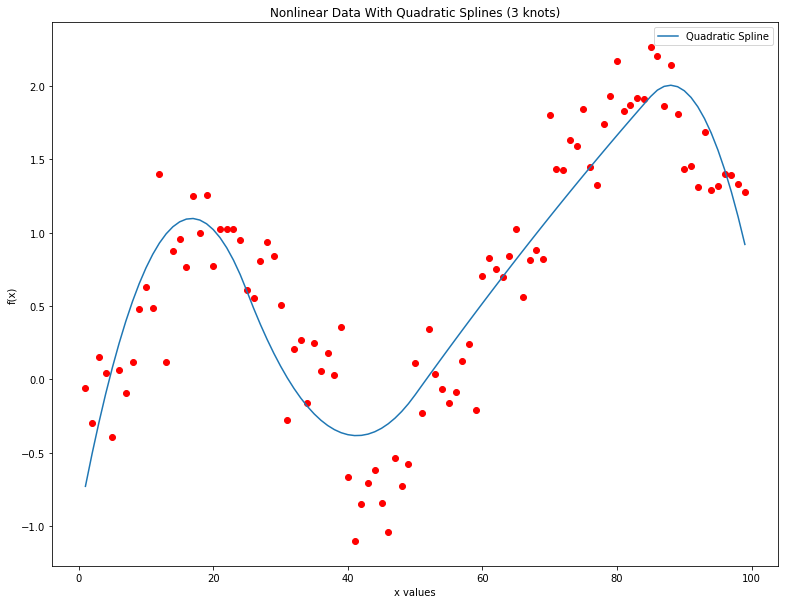

In [28]:
# Plot the non-linear data together linear splines
#Scatter plot of non-linear data
plot(xval, yval, 'ro')
xlabel("x values")
ylabel("f(x)")
title("Nonlinear Data With Quadratic Splines (3 knots)")

# Plot linear regression (degree 3)
pred_yhat = betahat[0] + betahat[1]*np.asarray(xval) + betahat[2]*np.asarray(xval_2) + betahat[3]*np.asarray(xval_q1) + betahat[4]*np.asarray(xval_q2)+ betahat[5]*np.asarray(xval_q3)
spline, = plot(xval, pred_yhat)

# Legend for linear regression scatter plot
legend([spline], ['Quadratic Spline'])
show()

## Conclusion

In this notebook we discussed 1) Polynomial regression, 2) Gaussian regression and 3) Spline regression for the purposes of fitting a model to nonlinear data $Y = f(x) + \epsilon.$ For highly nonlinear data we observed that polyonomial regression didn't perform very well and guassian and spline regression did a much better job fitting the data. When predicting $f(x^*),$ the gaussian regression is essentially a weighted average of points $f(x)$ for $x$ close to $x^*.$ Whereas a polynomial spline of degree $D$ is a function formed by connecting segements of polyonomials of degree $D$ together. 